In [13]:
from read_data import get_synth_data
import matplotlib.pyplot as plt
import numpy as np

from layers.dense import *
import tensorflow as tf
from quantilelosses import *

In [14]:
quantiles = [0.05, 0.95]
x_train, y_train, y_train_q = get_synth_data("Expo", x_min=-4,x_max= 4, n=5000, train=True, quantiles=quantiles)
x_test, y_test, y_test_q = get_synth_data("Expo", x_min=-7, x_max= 7, n=5000, train=True, quantiles=quantiles)

In [44]:
# define model with evidential output
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    DenseNormalGamma(len(quantiles)),
])

In [45]:
# Custom loss function to handle custom regularization
def loss(y, output):
    loss = 0.0
    mu, v, alpha, beta = tf.split(output, 4, axis=-1)
    for i, q in enumerate(quantiles):
        loss += quant_evi_loss(y, tf.expand_dims(mu[:,i], 1), tf.expand_dims(v[:,i],1),
                                    tf.expand_dims(alpha[:,i],1), tf.expand_dims(beta[:,i],1), q, 
                                    coeff=3e-1)
    return loss

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-3), 
                loss=loss)
model.fit(x_train, y_train, batch_size=64, epochs=500)

Epoch 1/500
79/79 [==============================] - 1s 2ms/step - loss: 18.7950
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 10.2322
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 9.1477
Epoch 4/500
79/79 [==============================] - 0s 2ms/step - loss: 8.8646
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 8.7201
Epoch 6/500
79/79 [==============================] - 0s 2ms/step - loss: 8.5972
Epoch 7/500
79/79 [==============================] - 0s 2ms/step - loss: 8.4852
Epoch 8/500
79/79 [==============================] - 0s 2ms/step - loss: 8.4445
Epoch 9/500
79/79 [==============================] - 0s 2ms/step - loss: 8.3627
Epoch 10/500
79/79 [==============================] - 0s 2ms/step - loss: 8.2970
Epoch 11/500
79/79 [==============================] - 0s 2ms/step - loss: 8.2821
Epoch 12/500
79/79 [==============================] - 0s 2ms/step - loss: 8.2324
Epoch 13/500
79/79 [===============

In [47]:
preds = model(x_test)
gamma, v, alpha, beta = tf.split(preds, 4, axis=-1)

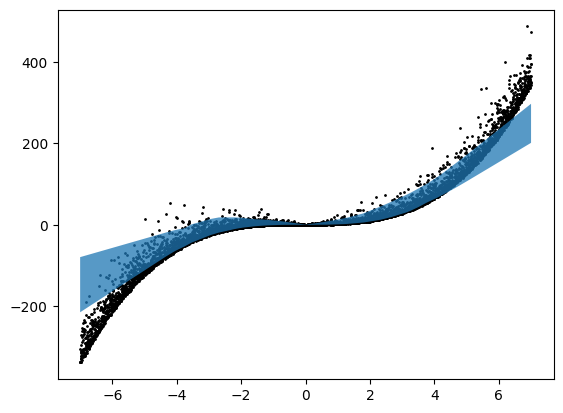

In [48]:
# plot of the quantile regression aleatoric uncertainty
plt.scatter(x_test, y_test, s=1, label='test', c='black')
plt.fill_between(x_test[:,0], gamma[:,0], gamma[:,1], alpha=0.75)

(-400.0, 400.0)

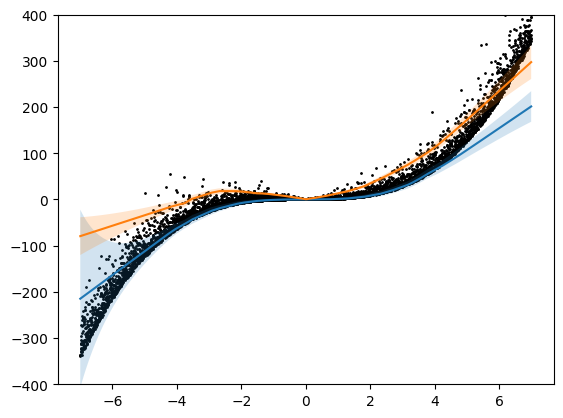

In [49]:
# plot of the quantile regression epistemic uncertainty
var = np.sqrt((beta /(v*(alpha - 1))))
plt.scatter(x_test, y_test, s=1, label='test', c='black')
plt.plot(x_test, gamma[:,0])
plt.plot(x_test, gamma[:,1])
plt.fill_between(x_test[:,0], gamma[:,0]+var[:,0], gamma[:,0]-var[:,0], alpha=0.2)
plt.fill_between(x_test[:,0], gamma[:,1]+var[:,1], gamma[:,1]-var[:,1], alpha=0.2)
plt.ylim(-400, 400)
